# Experiment tracking 

In [11]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("check-localhost-connection")

with mlflow.start_run():
    mlflow.log_metric("foo", 1)
    mlflow.log_metric("bar", 2)

2024/09/06 22:19:24 INFO mlflow.tracking.fluent: Experiment with name 'check-localhost-connection' does not exist. Creating a new experiment.
2024/09/06 22:19:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-bat-836 at: http://localhost:5000/#/experiments/825591646550238375/runs/c4398d2ddfbe4e05b9425854b21f75db.
2024/09/06 22:19:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/825591646550238375.


In [16]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.sklearn

with mlflow.start_run() as run:
    X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    params = {"max_depth": 2, "random_state": 42}
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    mlflow.set_tag("devloper","Venu")
    # Log parameters and metrics using the MLflow APIs
    mlflow.log_params(params)

    y_pred = model.predict(X_test)
    mlflow.log_metrics({"mse": mean_squared_error(y_test, y_pred)})

    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        input_example=X_train,
        registered_model_name="sk-learn-random-forest-reg-model",
        
    )
    
    # mlflow.set_experiment_tags("test")


Registered model 'sk-learn-random-forest-reg-model' already exists. Creating a new version of this model...
2024/09/05 14:57:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-random-forest-reg-model, version 5
Created version '5' of model 'sk-learn-random-forest-reg-model'.
2024/09/05 14:57:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-croc-154 at: http://localhost:5000/#/experiments/745768468464273167/runs/9b1222cdb1324982ba07939682bbac4a.
2024/09/05 14:57:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/745768468464273167.


In [4]:
# adding the tags 

In [5]:
from mlflow import MlflowClient

# Initialize an MLflow Client
client = MlflowClient()

In [7]:
def assign_alias_to_stage(model_name, stage, alias):
    """
    Assign an alias to the latest version of a registered model within a specified stage.

    :param model_name: The name of the registered model.
    :param stage: The stage of the model version for which the alias is to be assigned. Can be
                "Production", "Staging", "Archived", or "None".
    :param alias: The alias to assign to the model version.
    :return: None
    """
    latest_mv = client.get_latest_versions(model_name, stages=[stage])[0]
    client.set_registered_model_alias(model_name, alias, latest_mv.version)

In [19]:
import mlflow.sklearn
from mlflow.client import MlflowClient
from mlflow.models import infer_signature
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor


In [20]:
def print_model_version_info(mv):
    print(f"Name: {mv.name}")
    print(f"Version: {mv.version}")
    print(f"Source: {mv.source}")

In [21]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("check-client-1")

X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)

In [23]:
mlflow.set_experiment("check-client-1")
with mlflow.start_run() as run:
    params = {"n_estimators": 3, "random_state": 42}
    rfr = RandomForestRegressor(**params).fit(X, y)
    signature = infer_signature(X, rfr.predict(X))
    mlflow.log_params(params)
    mlflow.sklearn.log_model(rfr, artifact_path="sklearn-model", signature=signature)

2024/09/06 11:26:13 INFO mlflow.tracking.fluent: Experiment with name 'check-client-1' does not exist. Creating a new experiment.


2024/09/06 11:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-robin-164 at: http://localhost:5000/#/experiments/454918679885595293/runs/da2519d6e1214e48b2641169ddcf4ffe.
2024/09/06 11:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/454918679885595293.


In [25]:
run.info.run_id

'da2519d6e1214e48b2641169ddcf4ffe'

In [26]:
# Create source model version
client = MlflowClient()
src_name = "RandomForestRegression-staging"
client.create_registered_model(src_name)
src_uri = f"runs:/{run.info.run_id}/sklearn-model"
mv_src = client.create_model_version(src_name, src_uri, run.info.run_id)
print_model_version_info(mv_src)
print("--")

2024/09/06 11:29:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestRegression-staging, version 1


Name: RandomForestRegression-staging
Version: 1
Source: runs:/da2519d6e1214e48b2641169ddcf4ffe/sklearn-model
--


In [29]:
mv_src.version

'1'

In [30]:
dst_name = "RandomForestRegression-production"
src_model_uri = f"models:/{mv_src.name}/{mv_src.version}"
mv_copy = client.copy_model_version(src_model_uri, dst_name)
print_model_version_info(mv_copy)

Name: RandomForestRegression-production
Version: 1
Source: models:/RandomForestRegression-staging/1


Successfully registered model 'RandomForestRegression-production'.
Copied version '1' of model 'RandomForestRegression-staging' to version '1' of model 'RandomForestRegression-production'.


In [31]:
client.get_run('da2519d6e1214e48b2641169ddcf4ffe')

<Run: data=<RunData: metrics={}, params={'n_estimators': '3', 'random_state': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "da2519d6e1214e48b2641169ddcf4ffe", '
                             '"artifact_path": "sklearn-model", '
                             '"utc_time_created": "2024-09-06 '
                             '05:56:13.942842", "flavors": {"python_function": '
                             '{"model_path": "model.pkl", "predict_fn": '
                             '"predict", "loader_module": "mlflow.sklearn", '
                             '"python_version": "3.12.5", "env": {"conda": '
                             '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                             '"sklearn": {"pickled_model": "model.pkl", '
                             '"sklearn_version": "1.5.1", '
                             '"serialization_format": "cloudpickle", "code": '
                             'null}}, "model_uuid": '
                             '"d9507d82cad

In [33]:
name = "RandomForestRegression-production"
model = client.get_registered_model(name)

def print_model_info(rm):
    print("--Model--")
    print("name: {}".format(rm.name))
    print("aliases: {}".format(rm.aliases))

print_model_info(model)

# Create a new version of the rfr model under the registered model name
model_uri = "runs:/{}/sklearn-model".format(run.info.run_id)
mv = client.create_model_version(name, model_uri, run.info.run_id)
print_model_version_info(mv)

# Set registered model alias
client.set_registered_model_alias(name, "test-alias", mv.version)
print()

2024/09/06 11:37:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestRegression-production, version 2


--Model--
name: RandomForestRegression-production
aliases: {}
Name: RandomForestRegression-production
Version: 2
Source: runs:/da2519d6e1214e48b2641169ddcf4ffe/sklearn-model



# Q1 Install MLflow

In [1]:
import mlflow

In [2]:
mlflow.__version__

'2.16.0'

# Q2. Download and preprocess the data

In [7]:
# it will create 4 files 
# dv.pkl
# test.pkl
# train.pkl
# val.pkl


# Q3. Train a model with autolog

In [14]:
# min_samples_split  is 2



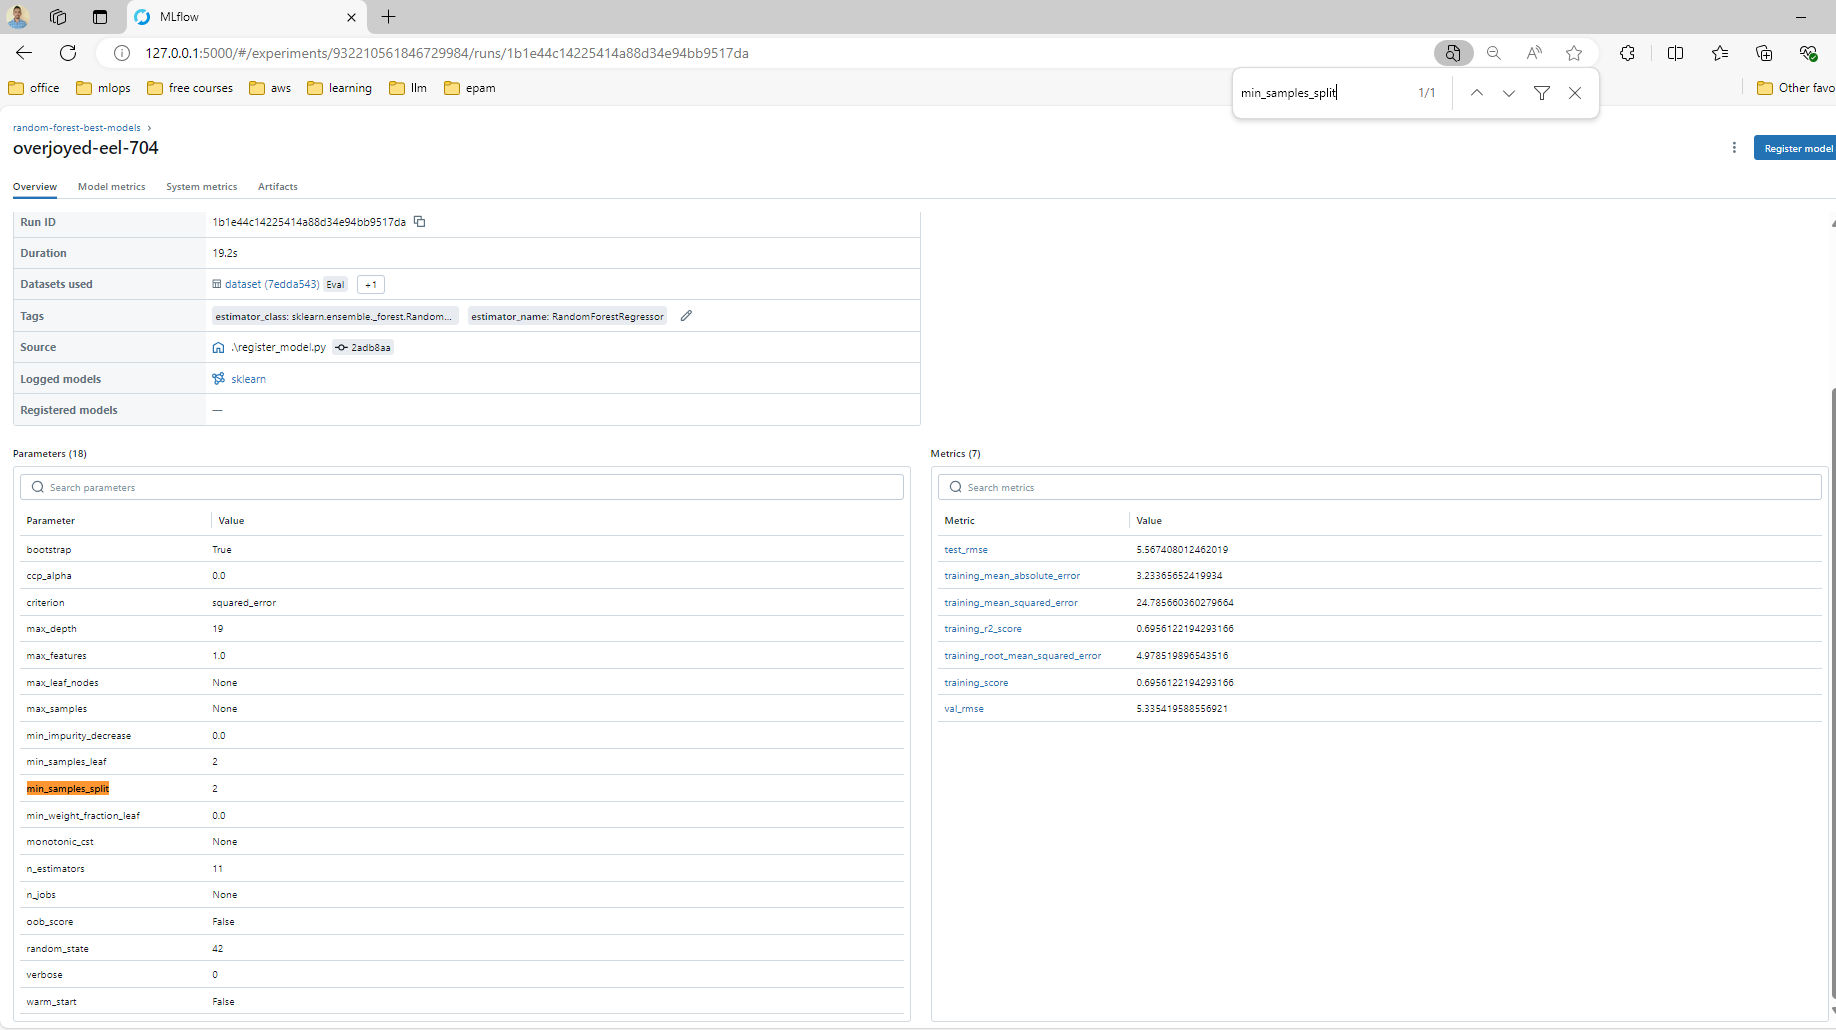

In [24]:
from IPython.display import display, Image
display(Image(filename="screenshorts/Screenshot 2024-09-09 102047.png"))

# Q4. Launch the tracking server locally

In [15]:
#  we need to pass default-artifact-root properly to configure the server

# Q5. Tune model hyperparameters

In [16]:
# 5.335 is low RMSE 

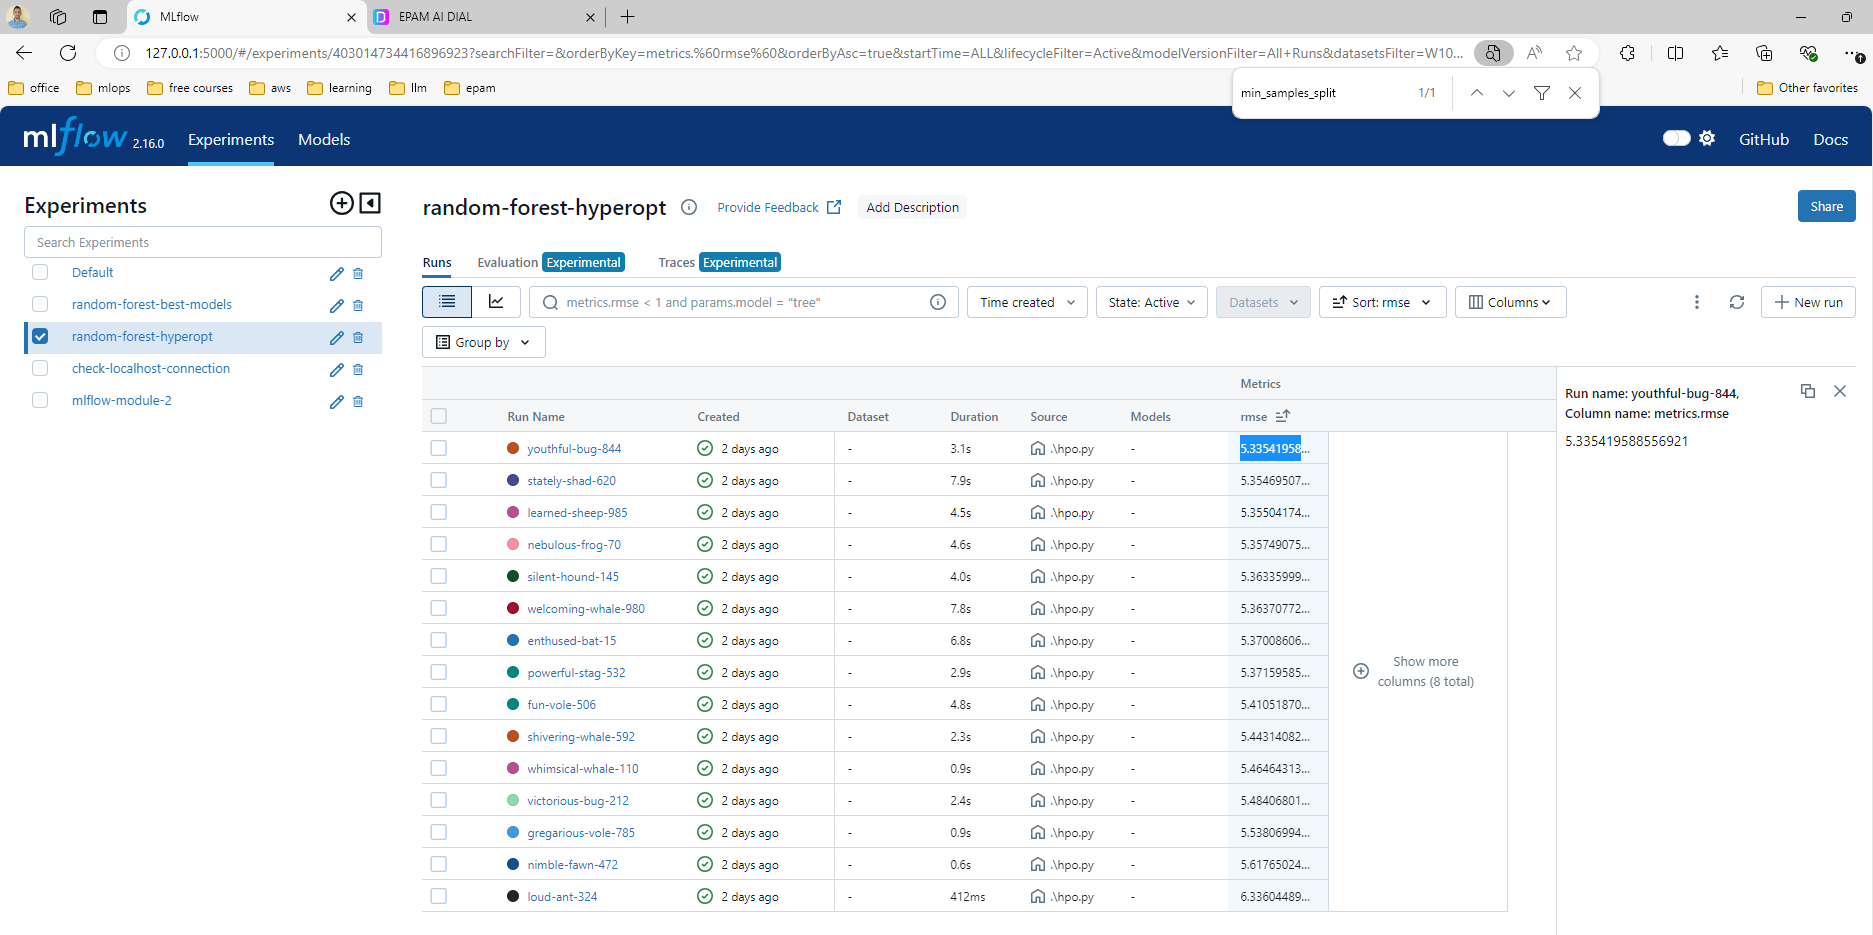

In [25]:
from IPython.display import display, Image
display(Image(filename="screenshorts/Screenshot 2024-09-09 103142.png"))

# Q6. Promote the best model to the model registry

In [17]:
# we already got the best model by searching in UI with 

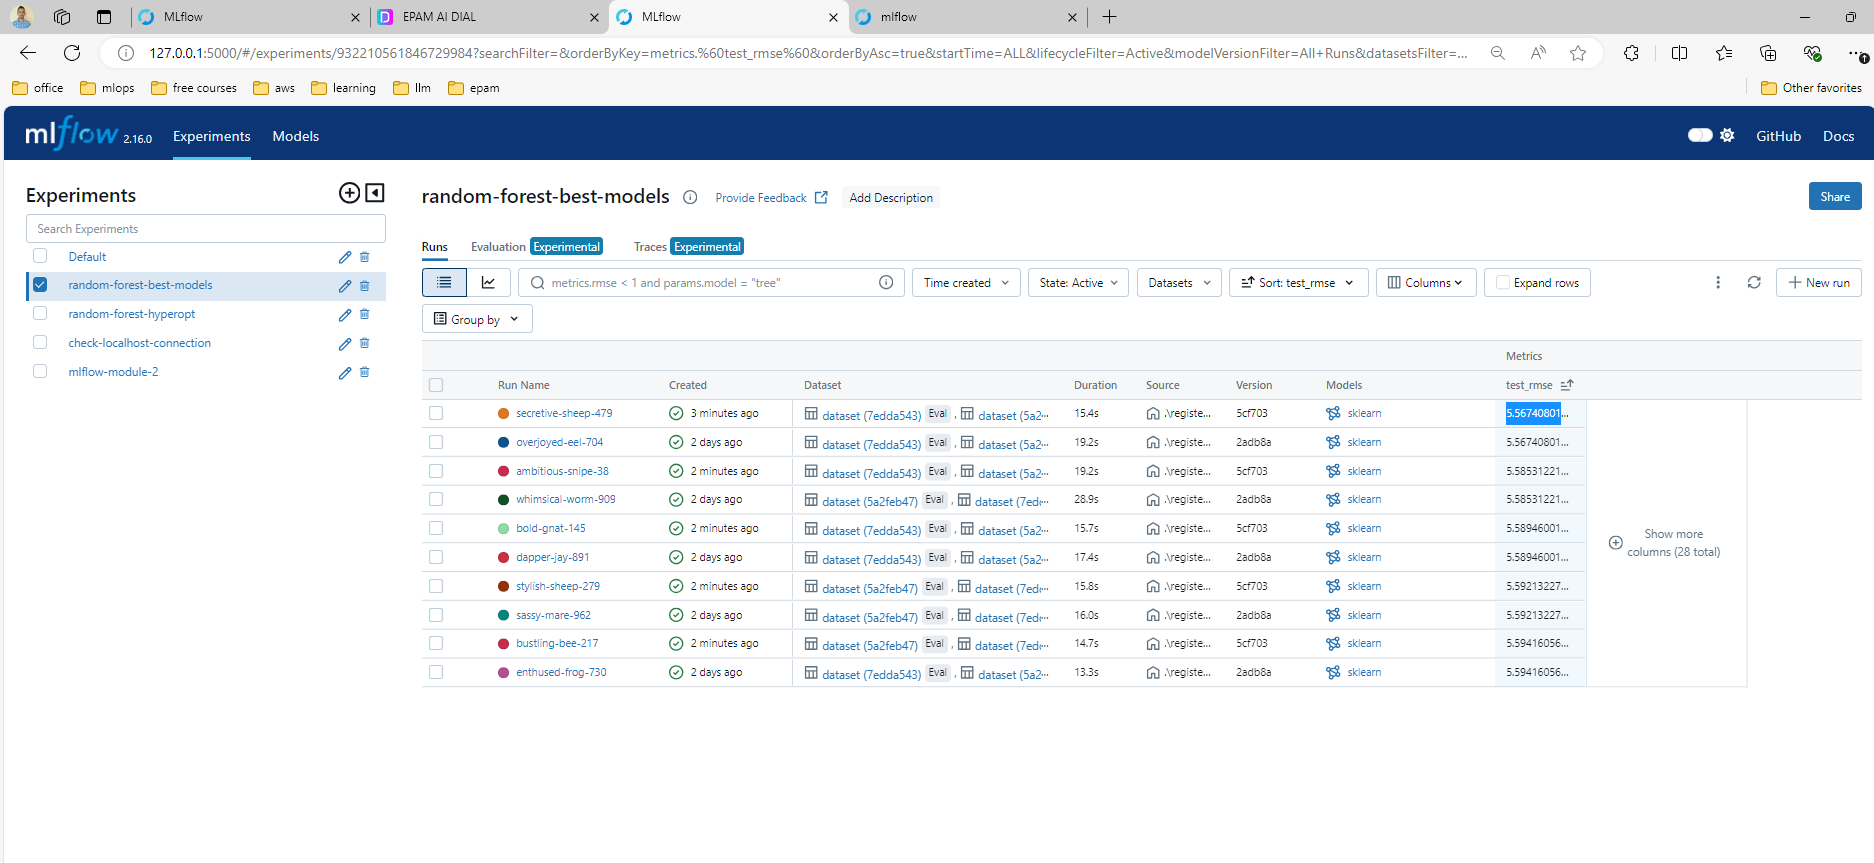

In [26]:
from IPython.display import display, Image
display(Image(filename="screenshorts/Screenshot 2024-09-09 103942.png"))

In [18]:
# now we are going to rigister the model 

In [19]:
run_id = "f8bbaef0ec9548a5a5019afdf302f4c8"
model_uri = f"runs:/{run_id}/sklearn-model"
mv = mlflow.register_model(model_uri, "RandomForestRegressionModel")

Successfully registered model 'RandomForestRegressionModel'.
2024/09/09 10:41:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestRegressionModel, version 1
Created version '1' of model 'RandomForestRegressionModel'.


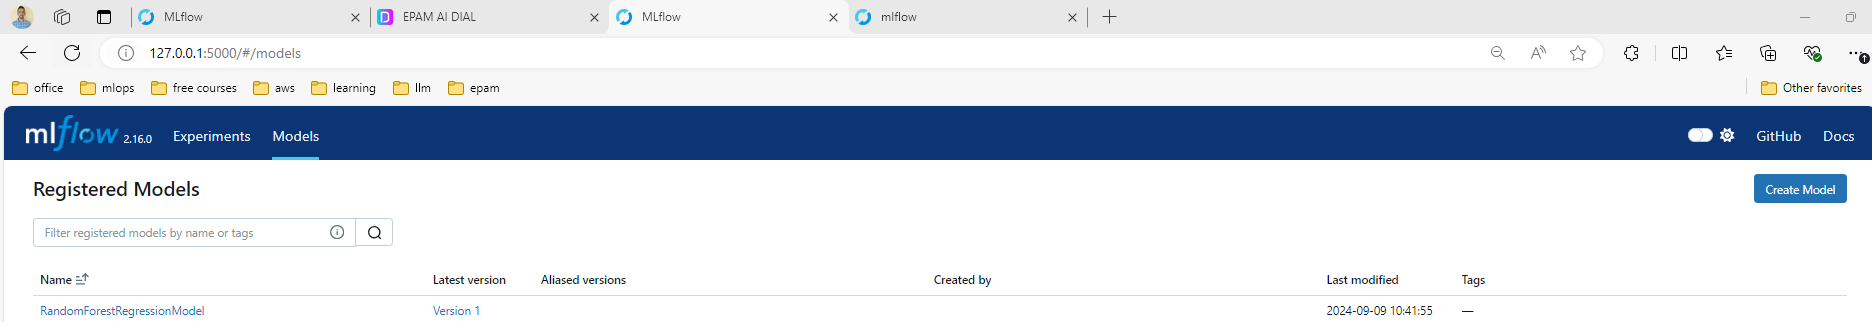

In [27]:
from IPython.display import display, Image
display(Image(filename="screenshorts/Screenshot 2024-09-09 104218.png"))

In [ ]:
# I try to attach the screeshorts along with some results 